Загрузка датасета MNIST. Я буду работать с ним прямо в задании 1.

In [1]:
from torchvision import  transforms, datasets
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize( (0.1307), (0.3081))
     ])

mnist = datasets.MNIST('MNIST', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('MNIST', train=False, download=True, transform=transform)

train_set, val_set , _ = random_split(mnist, [16000, 4000, 40000])

train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



Фиксируем seed для воспроизводимости результатов.

In [2]:
import random
import torch
import numpy as np
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

# Задание 1. Влияние инициализации весов

Изучаю влияние инициализации весов на скорость и качество обучения. Ставлю 4 эксперимента.

*Использую код из ячейки ниже (не мой, а скопированный) вкупе с matplotlib, чтобы выводить графики.*





In [3]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

class ProgressPlotter:
    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups
  
    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = [] #reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
           self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len,len(data[key]))
            if len(data) > 1:
               ax.legend(loc="upper right")
            if history_len < 50:
                ax.set_xlabel('step')
                ax.set_xticks(np.arange(history_len))
                ax.set_xticklabels(np.arange(history_len))
  
    """
        groups list of keys like [['loss_train','loss_val'],['accuracy']]
        All charts within a group will be plot in the same axis
    """
    def display(self, groups=None): 
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(48//n_groups, 3))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g]) 
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

Пример работы кода для визуализации:

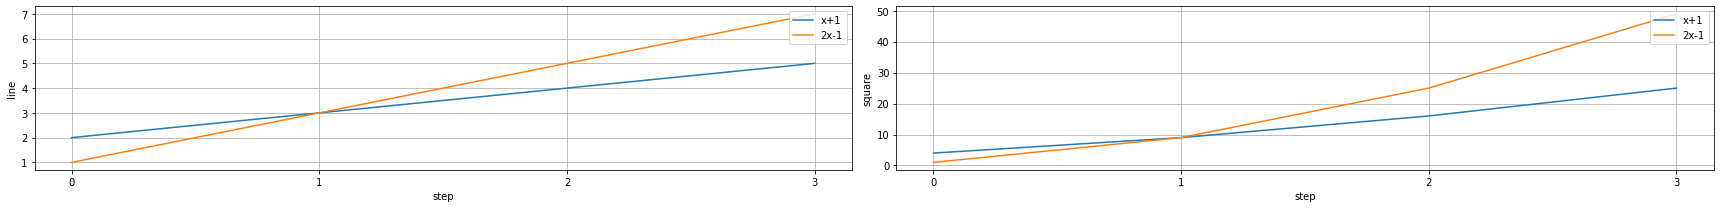

In [4]:
pp = ProgressPlotter(title='x+1')
for i in range(1, 5):
    pp.add_scalar('line', i + 1)
    pp.add_scalar('square', (i+1)**2)
pp.set_title('2x-1')
for i in range(1, 5):
    pp.add_scalar('line', 2*i - 1)
    pp.add_scalar('square', (2*i-1)**2)
pp.display(['line', 'square'])

Описываю модель LeNet:

In [5]:
import torch
import torch.nn as nn

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)        

    def forward(self, x):
      x = self.activation(self.pool(self.conv1(x)))
      x = self.activation(self.pool(self.conv2(x)))
      x = self.activation(self.fc1(x.flatten(start_dim=1)))
      x = self.activation(self.fc2(x))
      x = self.fc3(x)
      return x

In [6]:
def calaculate_accuracy(model, data_loader):
    correct, total = 0, 0 
    with torch.no_grad(): 
        for batch in data_loader: # get batch
            imgs, labels = batch # parse batch
            imgs, labels = imgs.to(device), labels.to(device)
            y_pred = model.forward(imgs) # get output
            _, predicted = torch.max(y_pred.data, 1) # get predicted class
            total += labels.size(0) # all examples
            correct += (predicted == labels).sum().item() # correct predictions 
    return correct / total 

## ReLU +  инициализация по умолчанию
Обучаю LeNet на 6-ти эпохах и вывожу график Loss. В качестве оптимизатора использую SGD.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # change run time to gpu to fast training

model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

num_epochs = 6
loss_hist = [] # for plotting
acc_hist=[]
for epoch in range(num_epochs):
    hist_loss = 0
    for _, batch in enumerate(train_loader, 0): # get batch
        # parse batch 
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        # sets the gradients of all optimized tensors to zero.
        optimizer.zero_grad() 
        # get outputs
        y_pred = model(imgs) 
        # calculate loss
        loss = criterion(y_pred, labels)
        # calculate gradients
        loss.backward() 
        # performs a single optimization step (parameter update)
        optimizer.step()
        hist_loss += loss.item()
    loss_hist.append(hist_loss / len(train_loader))
    acc_hist.append(round(calaculate_accuracy(model, val_loader), 3))
    print(f"Epoch={epoch} loss={loss_hist[epoch]:.4f}")

Epoch=0 loss=2.3429
Epoch=1 loss=2.3026
Epoch=2 loss=2.3027
Epoch=3 loss=2.3032
Epoch=4 loss=2.3025
Epoch=5 loss=2.3027


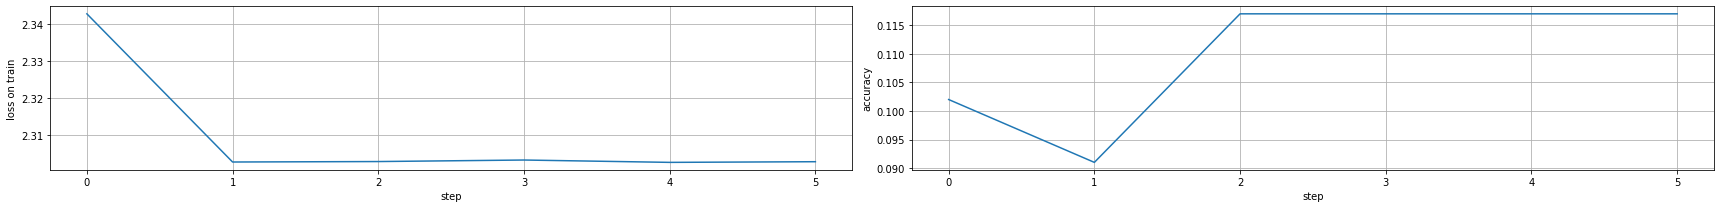

In [9]:
#plt.plot(range(num_epochs), loss_hist)
#plt.xlabel("Epochs", fontsize=15)
#plt.ylabel("Loss", fontsize=15)
#plt.show()

pp = ProgressPlotter(title='relu_default')
for x in loss_hist:
    pp.add_scalar('loss on train', x)
for x in acc_hist:
    pp.add_scalar('accuracy', x)
# pp.set_title('2x-1') понадобится при следующем написании
pp.display(['loss on train', 'accuracy'])

## Tanh
Просто заменяю функцию акивации на nn.Tanh. Вывожу график loss в тех же осях.

In [10]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.Tanh()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)        

    def forward(self, x):
      x = self.activation(self.pool(self.conv1(x)))
      x = self.activation(self.pool(self.conv2(x)))
      x = self.activation(self.fc1(x.flatten(start_dim=1)))
      x = self.activation(self.fc2(x))
      x = self.fc3(x)
      return x

In [11]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

num_epochs = 6
loss_hist = [] # for plotting
acc_hist=[]
for epoch in range(num_epochs):
    hist_loss = 0
    for _, batch in enumerate(train_loader, 0): # get batch
        # parse batch 
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        # sets the gradients of all optimized tensors to zero.
        optimizer.zero_grad() 
        # get outputs
        y_pred = model(imgs) 
        # calculate loss
        loss = criterion(y_pred, labels)
        # calculate gradients
        loss.backward() 
        # performs a single optimization step (parameter update)
        optimizer.step()
        hist_loss += loss.item()
    loss_hist.append(hist_loss / len(train_loader))
    acc_hist.append(round(calaculate_accuracy(model, val_loader), 3))
    print(f"Epoch={epoch} loss={loss_hist[epoch]:.4f}")

Epoch=0 loss=0.6889
Epoch=1 loss=0.2005
Epoch=2 loss=0.1672
Epoch=3 loss=0.1734
Epoch=4 loss=0.1529
Epoch=5 loss=0.1536


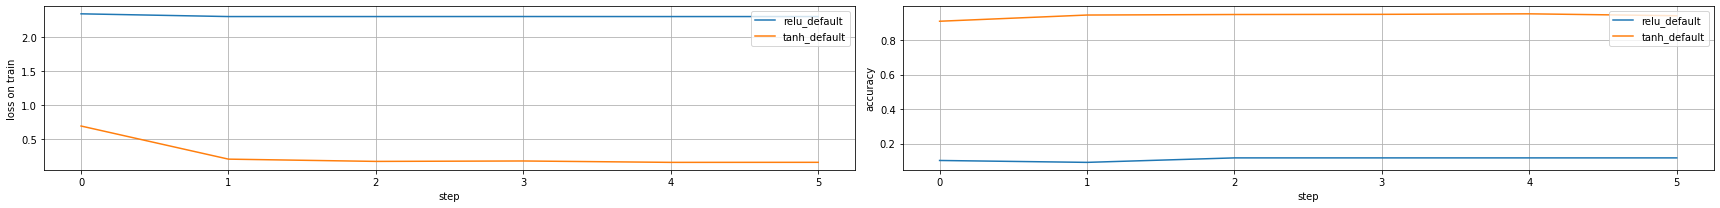

In [12]:
pp.set_title('tanh_default')
for x in loss_hist:
    pp.add_scalar('loss on train', x)
for x in acc_hist:
    pp.add_scalar('accuracy', x)
pp.display(['loss on train', 'accuracy'])

## Tanh + Zavier

Инициализирую веса при помощи алгоритма [Завьера](https://pytorch.org/docs/stable/nn.init.html).
По прежнему использую nn.Tanh. Вывожу график Loss в тех же осях.

In [13]:
class LeNet(nn.Module): # в правильном месте инициализирую? Мб отдельным методом стоит?
    def __init__(self):
        super().__init__()
        self.activation = nn.Tanh()
        self.conv1 = nn.Conv2d(1, 6, 5)
        nn.init.xavier_uniform(self.conv1.weight,gain=nn.init.calculate_gain('tanh'))
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        nn.init.xavier_uniform(self.conv2.weight,gain=nn.init.calculate_gain('tanh'))
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 5*5 from image dimension
        nn.init.xavier_uniform(self.fc1.weight,gain=nn.init.calculate_gain('tanh'))
        self.fc2 = nn.Linear(120, 84)
        nn.init.xavier_uniform(self.fc2.weight,gain=nn.init.calculate_gain('tanh'))
        self.fc3 = nn.Linear(84, 10)   
        nn.init.xavier_uniform(self.fc3.weight,gain=nn.init.calculate_gain('tanh'))     

    def forward(self, x):
      x = self.activation(self.pool(self.conv1(x)))
      x = self.activation(self.pool(self.conv2(x)))
      x = self.activation(self.fc1(x.flatten(start_dim=1)))
      x = self.activation(self.fc2(x))
      x = self.fc3(x)
      return x

In [14]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

num_epochs = 6
loss_hist = [] # for plotting
acc_hist=[]
for epoch in range(num_epochs):
    hist_loss = 0
    for _, batch in enumerate(train_loader, 0): # get batch
        # parse batch 
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        # sets the gradients of all optimized tensors to zero.
        optimizer.zero_grad() 
        # get outputs
        y_pred = model(imgs) 
        # calculate loss
        loss = criterion(y_pred, labels)
        # calculate gradients
        loss.backward() 
        # performs a single optimization step (parameter update)
        optimizer.step()
        hist_loss += loss.item()
    loss_hist.append(hist_loss / len(train_loader))
    acc_hist.append(round(calaculate_accuracy(model, val_loader), 3))
    print(f"Epoch={epoch} loss={loss_hist[epoch]:.4f}")

<ipython-input-13-22cd829bcba6>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.conv1.weight,gain=nn.init.calculate_gain('tanh'))
<ipython-input-13-22cd829bcba6>:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.conv2.weight,gain=nn.init.calculate_gain('tanh'))
<ipython-input-13-22cd829bcba6>:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.fc1.weight,gain=nn.init.calculate_gain('tanh'))
<ipython-input-13-22cd829bcba6>:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.fc2.weight,gain=nn.init.calculate_gain('tanh'))
<ipython-input-13-22cd829bcba6>:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.fc3.weight,gain=nn.i

Epoch=0 loss=1.3453
Epoch=1 loss=0.3390
Epoch=2 loss=0.2526
Epoch=3 loss=0.2395
Epoch=4 loss=0.2136
Epoch=5 loss=0.2190


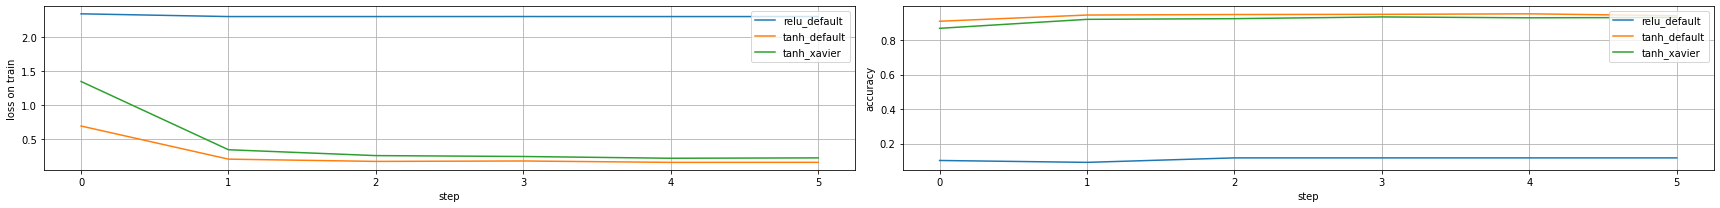

In [15]:
pp.set_title('tanh_xavier')
for x in loss_hist:
    pp.add_scalar('loss on train', x)
for x in acc_hist:
    pp.add_scalar('accuracy', x)
pp.display(['loss on train', 'accuracy'])

## ReLU + Kaiming

Теперь заменяю функцию активации на ReLU и инициализирую веса при помощи алгоритма [Kaiming](https://pytorch.org/docs/stable/nn.init.html).
Вывожу график Loss в тех же осях.


In [16]:
import torch
import torch.nn as nn

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 6, 5)
        nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='relu')
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 5*5 from image dimension
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.fc2 = nn.Linear(120, 84)
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        self.fc3 = nn.Linear(84, 10)        
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')

    def forward(self, x):
      x = self.activation(self.pool(self.conv1(x)))
      x = self.activation(self.pool(self.conv2(x)))
      x = self.activation(self.fc1(x.flatten(start_dim=1)))
      x = self.activation(self.fc2(x))
      x = self.fc3(x)
      return x

In [17]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

num_epochs = 6
loss_hist = [] # for plotting
acc_hist=[]
for epoch in range(num_epochs):
    hist_loss = 0
    for _, batch in enumerate(train_loader, 0): # get batch
        # parse batch 
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        # sets the gradients of all optimized tensors to zero.
        optimizer.zero_grad() 
        # get outputs
        y_pred = model(imgs) 
        # calculate loss
        loss = criterion(y_pred, labels)
        # calculate gradients
        loss.backward() 
        # performs a single optimization step (parameter update)
        optimizer.step()
        hist_loss += loss.item()
    loss_hist.append(hist_loss / len(train_loader))
    acc_hist.append(round(calaculate_accuracy(model, val_loader), 3))
    print(f"Epoch={epoch} loss={loss_hist[epoch]:.4f}")

Epoch=0 loss=2.8973
Epoch=1 loss=0.9420
Epoch=2 loss=0.5530
Epoch=3 loss=0.4241
Epoch=4 loss=0.3770
Epoch=5 loss=0.3164


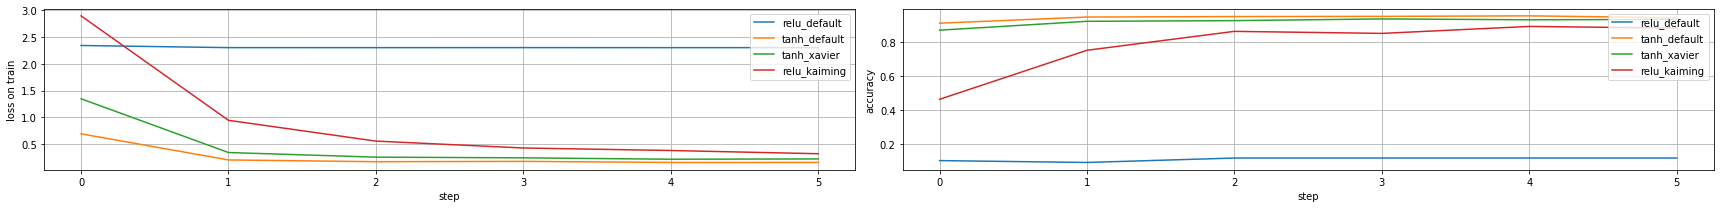

In [18]:
pp.set_title('relu_kaiming')
for x in loss_hist:
    pp.add_scalar('loss on train', x)
for x in acc_hist:
    pp.add_scalar('accuracy', x)
pp.display(['loss on train', 'accuracy'])

# Задание 2. Сравнение оптимизаторов

В этом задании  нужно обучить модель из прошлого задания тремя способами:
- с оптимизатором с моментом,
- с адаптивным оптимизатором,
- с простым SGD (без momentum и прочих дополнительных параметров) и циклическим learning rate (нужно будет подобрать диапазон скоростей обучения). 


Я построю графики Loss и accuracy и сравню качество и скорость обучения.

In [19]:
import torch
import torch.nn as nn

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)        

    def forward(self, x):
      x = self.activation(self.pool(self.conv1(x)))
      x = self.activation(self.pool(self.conv2(x)))
      x = self.activation(self.fc1(x.flatten(start_dim=1)))
      x = self.activation(self.fc2(x))
      x = self.fc3(x)
      return x

In [20]:
def calaculate_accuracy(model, data_loader):
    correct, total = 0, 0 
    with torch.no_grad(): 
        for batch in data_loader: # get batch
            imgs, labels = batch # parse batch
            imgs, labels = imgs.to(device), labels.to(device)
            y_pred = model.forward(imgs) # get output
            _, predicted = torch.max(y_pred.data, 1) # get predicted class
            total += labels.size(0) # all examples
            correct += (predicted == labels).sum().item() # correct predictions 
    return correct / total 


def train(model,optimizer):
    criterion = nn.CrossEntropyLoss()

    num_epochs = 6
    loss_hist = [] # for plotting
    acc_hist=[]
    for epoch in range(num_epochs):
        hist_loss = 0
        for _, batch in enumerate(train_loader, 0): # get batch
            # parse batch 
            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)
            # sets the gradients of all optimized tensors to zero.
            optimizer.zero_grad() 
            # get outputs
            y_pred = model(imgs) 
            # calculate loss
            loss = criterion(y_pred, labels)
            # calculate gradients
            loss.backward() 
            # performs a single optimization step (parameter update)
            optimizer.step()
            hist_loss += loss.item()
        loss_hist.append(hist_loss / len(train_loader))
        acc_hist.append(round(calaculate_accuracy(model, val_loader), 3))
        print(f"Epoch={epoch} loss={loss_hist[epoch]:.4f}")
    return loss_hist, acc_hist


## Оптимизатор с моментом

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # change run time to gpu to fast training

model = LeNet().to(device)
loss_hist, acc_hist=train(model,optimizer=torch.optim.SGD(model.parameters(),momentum=0.9, lr=0.001) )

Epoch=0 loss=2.3008
Epoch=1 loss=2.2841
Epoch=2 loss=2.2578
Epoch=3 loss=2.2001
Epoch=4 loss=2.0266
Epoch=5 loss=1.4536


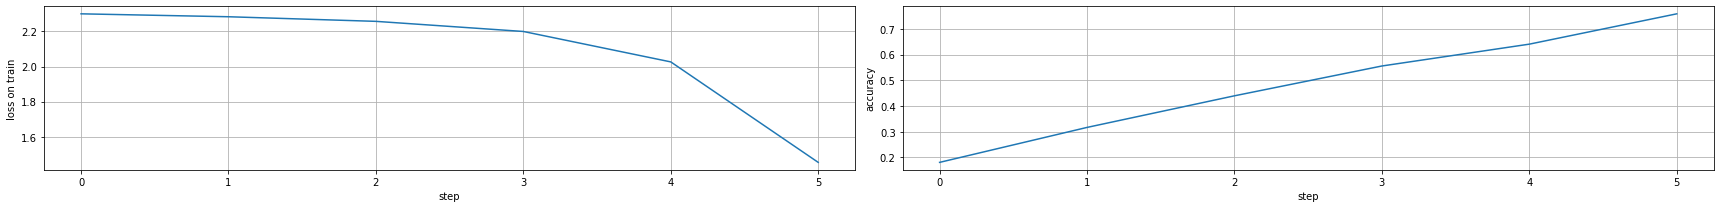

In [22]:
pp = ProgressPlotter(title='SGD_momentum')
for x in loss_hist:
    pp.add_scalar('loss on train', x)
for x in acc_hist:
    pp.add_scalar('accuracy', x)
pp.display(['loss on train', 'accuracy'])

## Адаптивный оптимизатор

In [23]:
model = LeNet().to(device)
loss_hist, acc_hist=train(model,optimizer=torch.optim.Adam(model.parameters(), lr=0.001) )

Epoch=0 loss=1.0539
Epoch=1 loss=0.3082
Epoch=2 loss=0.2162
Epoch=3 loss=0.1634
Epoch=4 loss=0.1369
Epoch=5 loss=0.1136


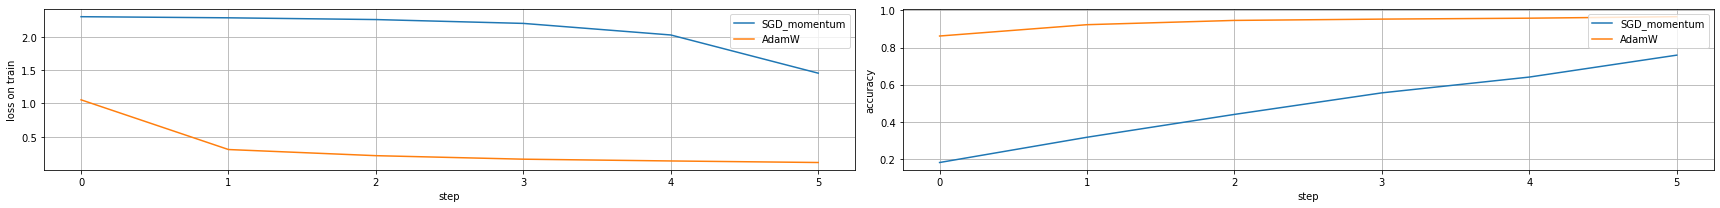

In [24]:
pp.set_title('AdamW')
for x in loss_hist:
    pp.add_scalar('loss on train', x)
for x in acc_hist:
    pp.add_scalar('accuracy', x)
pp.display(['loss on train', 'accuracy'])

## Циклический learning rate
Теперь попробую обучить ту же архитектуру при помощи комбинации SGD (без momentum и прочих дополнительных параметров) и циклического learning rate.

Вот для подбора learning rate для циклического lr я использую код из лекции по этой теме. По рекомендации значения подбираю в диапазоне $[10^{-3}, 1]$) и исптользую параметры `step_size_up=40, step_size_down=40`.



In [25]:
from tqdm import tqdm
import math

start_lr = 1e-3
end_lr = 1
lr_find_epochs = 6
steps = lr_find_epochs * len(train_loader)
smoothing = 0.05

model = LeNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)


lrs = []
losses = []
optimizer = torch.optim.SGD(model.parameters(), lr=1e-8)
lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (steps))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

for epoch in tqdm(range(lr_find_epochs)):
    for batch in train_loader:
        optimizer.zero_grad()
        x_train, y_train = batch
        x_train, y_train = x_train.to(device), y_train.to(device)
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)

        loss.backward()
        optimizer.step()
        scheduler.step()

        loss = loss.detach().cpu().numpy()
        if len(losses) > 1:
            loss = smoothing * loss + (1 - smoothing) * losses[-1]
        losses.append(loss)
        lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
        lrs.append(lr_step)

100%|██████████| 6/6 [00:16<00:00,  2.67s/it]


In [26]:
min_lr = 1e-3
max_lr = 1

def train_epoch_sh(model, optimizer, scheduler, criterion, train_loader):
    loss_history = []
    for batch in train_loader:
        optimizer.zero_grad()
        x_train, y_train = batch  # parse data
        x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
        y_pred = model(x_train)  # get predictions
        loss = criterion(y_pred, y_train)  # compute loss
        loss_history.append(loss.cpu().detach().numpy())  # write loss to log
        loss.backward()
        optimizer.step()
        scheduler.step()
    loss_sum=sum(loss_history)/len(train_loader)
    return loss_sum


In [27]:
model = model = LeNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=min_lr)

scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer, base_lr=min_lr, max_lr=max_lr, mode="triangular"
)  # first case

In [28]:
from copy import deepcopy


def train_model_cycle_sh(model, optimizer, scheduler, model_name=None, num_epochs=6):

    criterion = nn.CrossEntropyLoss().to(device)

    train_history = {}
    train_history["model_name"] = model_name
    train_history["loss_on_train"] = []
    train_history["loss_on_test"] = []
    train_history["accuracy_history"]=[]

    best_loss = np.inf

    for epoch in tqdm(range(num_epochs)):
        model.train()
        loss_on_train = train_epoch_sh(
            model, optimizer, scheduler, criterion, train_loader
        )
        model.eval()
        val_loss, loss_on_test = validate(model, criterion, val_loader)
        train_history["loss_on_train"].append(loss_on_train)
        train_history["loss_on_test"].extend(loss_on_test)
        train_history["accuracy_history"].append(round(calaculate_accuracy(model, val_loader), 3) )
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = deepcopy(model)
    return best_model, train_history


In [29]:
def validate(model, criterion, val_loader):
    cumloss = 0
    loss_history = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train = batch  # parse data
            x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
            y_pred = model(x_train)  # get predictions
            loss = criterion(y_pred, y_train)  # compute loss
            loss_history.append(loss.cpu().detach().numpy())  # write loss to log
            cumloss += loss
    return cumloss / len(val_loader), loss_history  # mean loss and history

In [30]:
best_model, history = train_model_cycle_sh(
    model, optimizer, scheduler, model_name="sgd_cycle_lr", num_epochs=6
)

100%|██████████| 6/6 [00:25<00:00,  4.24s/it]


In [31]:
print(len(history["loss_on_train"]),len(history["accuracy_history"]))

6 6


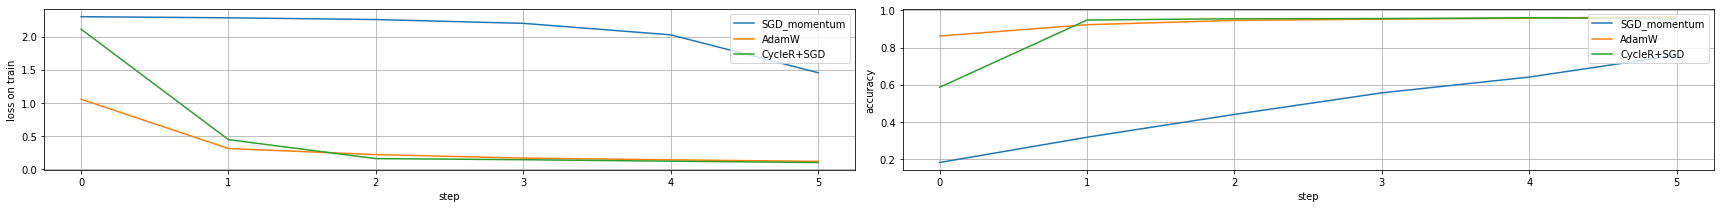

In [32]:
pp.set_title('CycleR+SGD')
for x in history["loss_on_train"]:
    pp.add_scalar('loss on train', x)
for x in history["accuracy_history"]:
    pp.add_scalar('accuracy', x)
pp.display(['loss on train', 'accuracy'])

# Задание 3. Dropout

Добавляю в мою нейросеть Dropout на последних слоях. 

Обучаю ее на наборе данных MNIST. После этого делаю предсказание на тестовом датасете, не делая model.eval. Повторяю процедуру предсказания 20 раз. 


\\

Хочу еще сделать такое, но времени пока нет:

Вывести 10 изображений, в классификации которых нейросеть больше всего не уверена (на 20 запусках предсказывала им самые различные классы) и 10 изображений, в классификации которых нейросеть больше всего уверена. 

Так что все обучено и точность посчитана, но вывод картинок добавлю как-нибудь потом.



In [33]:
def calaculate_accuracy(model, data_loader):
    correct, total = 0, 0 
    model.train() # мучу трейн мод
    with torch.no_grad(): 
        for batch in data_loader: # get batch
            imgs, labels = batch # parse batch
            imgs, labels = imgs.to(device), labels.to(device)
            y_pred = model.forward(imgs) # get output
            _, predicted = torch.max(y_pred.data, 1) # get predicted class
            total += labels.size(0) # all examples
            correct += (predicted == labels).sum().item() # correct predictions 
    return correct / total 

In [34]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2)
        self.flt=nn.Flatten()
        self.drp=nn.Dropout(0.2)   
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)     

    def forward(self, x):
      x = self.activation(self.pool(self.conv1(x)))
      x = self.activation(self.pool(self.conv2(x)))
      x=self.flt(x)
      x=self.drp(x)
      x = self.activation(self.fc1(x))
      x = self.activation(self.fc2(x))
      x = self.fc3(x)
      return x

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # change run time to gpu to fast training

model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 10
loss_hist = [] # for plotting
acc_hist=[]
for epoch in range(num_epochs):
    hist_loss = 0
    for _, batch in enumerate(train_loader, 0): # get batch
        # parse batch 
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        # sets the gradients of all optimized tensors to zero.
        optimizer.zero_grad() 
        # get outputs
        y_pred = model(imgs) 
        # calculate loss
        loss = criterion(y_pred, labels)
        # calculate gradients
        loss.backward() 
        # performs a single optimization step (parameter update)
        optimizer.step()
        hist_loss += loss.item()
    loss_hist.append(hist_loss / len(train_loader))
    acc_hist.append(round(calaculate_accuracy(model, val_loader), 3))
    print(f"Epoch={epoch} loss={loss_hist[epoch]:.4f}")

Epoch=0 loss=0.5914
Epoch=1 loss=0.1374
Epoch=2 loss=0.1029
Epoch=3 loss=0.0900
Epoch=4 loss=0.0848
Epoch=5 loss=0.0679
Epoch=6 loss=0.0730
Epoch=7 loss=0.0555
Epoch=8 loss=0.0517
Epoch=9 loss=0.0590


In [36]:
for i in range(20):
    x=round(calaculate_accuracy(model, val_loader), 3)

# Задание 4. Глубокая сеть

Описываю сверточную архитектуру для классификации CIFAR10. Использую [BatchNorm](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm#torch.nn.BatchNorm2d) между слоями и другие техники улучшения сходимости. Точно уже хорошая.

Загрузим CIFAR10

In [37]:
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(
                                                [0.4914, 0.4822, 0.4465],
                                                [0.2470, 0.2434, 0.2615])])

cifar = CIFAR10(root='CIFAR10', train=True, download=True, transform=transform)
cifat_test = CIFAR10(root='CIFAR10', train=False, download=True, transform=transform)

train_set_cifar, val_set_cifar, = torch.utils.data.random_split(cifar, [45000, 5000])

batch_size = 256

train_loader_cifar = DataLoader(train_set_cifar, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader_cifar = DataLoader(val_set_cifar, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_cifar = DataLoader(cifat_test, batch_size=batch_size, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10
Files already downloaded and verified


In [38]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__() #я уже когда-то сохранял такую архитектуру 
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Dropout(0.2),
            nn.Linear(256*4*4, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)



In [39]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

num_epochs = 6
loss_hist = [] # for plotting
acc_hist=[]
for epoch in range(num_epochs):
    hist_loss = 0
    for _, batch in enumerate(train_loader_cifar, 0): # get batch
        # parse batch 
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        # sets the gradients of all optimized tensors to zero.
        optimizer.zero_grad() 
        # get outputs
        y_pred = model(imgs) 
        # calculate loss
        loss = criterion(y_pred, labels)
        # calculate gradients
        loss.backward() 
        # performs a single optimization step (parameter update)
        optimizer.step()
        hist_loss += loss.item()
    loss_hist.append(hist_loss / len(train_loader_cifar))
    acc_hist.append(round(calaculate_accuracy(model, test_loader_cifar), 3))
    print(f"Epoch={epoch} loss={loss_hist[epoch]:.4f}")


Epoch=0 loss=1.7176
Epoch=1 loss=1.0880
Epoch=2 loss=0.7820
Epoch=3 loss=0.6270
Epoch=4 loss=0.5177
Epoch=5 loss=0.4338


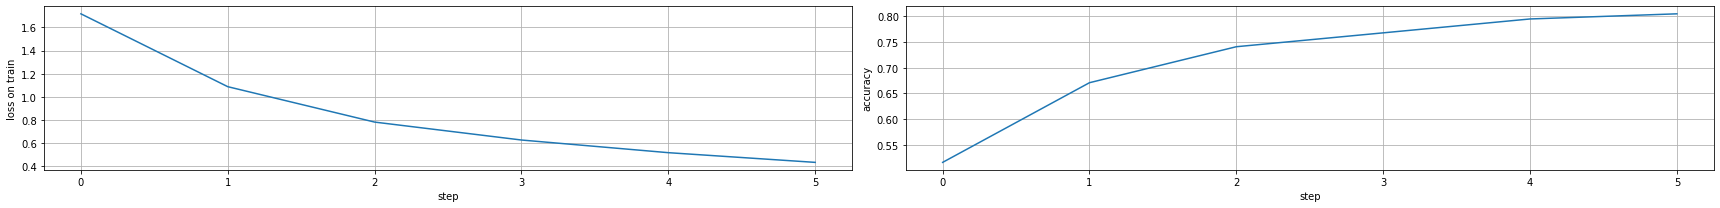

In [40]:
pp = ProgressPlotter()
for x in loss_hist:
    pp.add_scalar('loss on train', x)
for x in acc_hist:
    pp.add_scalar('accuracy', x)
pp.display(['loss on train', 'accuracy'])

In [41]:
print("Короче, точность такая:", acc_hist[len(acc_hist)-1])

Короче, точность такая: 0.805
